In [142]:
import numpy as np
import pandas as pd
import statsmodels.tsa.seasonal as STL
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from IPython.display import display

testData_01 = pd.read_csv("./TestdatenSet1.csv")
print(testData_01)

# Do one with electrity and one with voltage



       Id              Zeitstempel MaschinenID  ...  Strom  WirkLeistung   Arbeit
0      96  2025-08-04 10:49:15.287  HELLER_PT5  ...    NaN           NaN      NaN
1      97  2025-08-04 11:22:01.020  HELLER_PT5  ...    NaN           NaN      NaN
2      98  2025-08-04 11:24:27.807  HELLER_PT5  ...    NaN           NaN      NaN
3      99  2025-08-04 11:26:07.867  HELLER_PT5  ...    NaN           NaN      NaN
4     100  2025-08-04 11:30:28.233  HELLER_PT5  ...    NaN           NaN      NaN
..    ...                      ...         ...  ...    ...           ...      ...
995  1091  2025-08-21 12:19:32.197  HELLER_PT5  ...    NaN           NaN      NaN
996  1092  2025-08-21 12:19:39.117  HELLER_PT5  ...    NaN           NaN      NaN
997  1093  2025-08-21 12:19:44.327  HELLER_PT5  ...    NaN           NaN      NaN
998  1094  2025-08-21 12:19:49.933  HELLER_PT5  ...    NaN           NaN      NaN
999  1095  2025-08-21 12:23:37.007  HELLER_PT5  ...  2,205        260,75  51780.0

[1000 rows x 50

In [143]:
# Strom pipeline
testData_01_power_df = testData_01[["Zeitstempel", "Strom"]].copy()
# We will assume for now that NaN is equivalent to the machine just not running; optional: we could try to build a missing value handler 
# based on linear interpolation (does that even make sense with electricity?) or maybe by estimating a value via loess regression
# set up dataframe with timestamp as an index 
testData_01_power_df.rename(columns= {"Zeitstempel": "Timestamp", "Strom": "Power"}, inplace = True)
testData_01_power_df["Power"] = testData_01_power_df["Power"].str.replace(",", ".", regex=False)
testData_01_power_df["Power"] = pd.to_numeric(testData_01_power_df["Power"], errors = "raise") # if errors then its put into an NaN state
testData_01_power_df.dropna(subset=["Power"], inplace = True)
# print(testData_01_power_df)

# setting up index and interpolate to get missing values 
testData_01_power_df["Timestamp"] = pd.to_datetime(testData_01_power_df["Timestamp"])
testData_01_power_df.set_index("Timestamp", inplace=True)
print(testData_01_power_df)

# most_common_time_inseconds = testData_01_power_df.index.to_series().diff().value_counts().head().index[0].total_seconds()
# testData_01_power_df = testData_01_power_df.resample(pd.Timedelta(seconds=most_common_time_inseconds)).mean()
# testData_01_power_df = testData_01_power_df.interpolate(method="time")
# print(testData_01_power_df)
testData_01_power_df.index = (testData_01_power_df.index  - testData_01_power_df.index[0]).total_seconds()
testData_01_power_df.drop(testData_01_power_df.index[-1], inplace=True)
pd.reset_option("all")
display(testData_01_power_df)



                          Power
Timestamp                      
2025-08-13 13:14:31.907  1.9775
2025-08-13 13:14:39.533  1.7675
2025-08-13 13:14:45.640  1.8025
2025-08-13 13:14:51.660  1.8025
2025-08-13 13:14:57.687  1.8025
...                         ...
2025-08-13 13:43:01.807  1.6800
2025-08-13 13:43:10.727  1.6975
2025-08-13 13:43:16.730  1.7150
2025-08-13 13:43:22.850  1.7150
2025-08-21 12:23:37.007  2.2050

[365 rows x 1 columns]


C:\Users\PLenski\AppData\Local\Temp\ipykernel_19176\3740100787.py:23: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option("all")
C:\Users\PLenski\AppData\Local\Temp\ipykernel_19176\3740100787.py:23: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


,Power
Timestamp,
0.000,1.9775
7.626,1.7675
13.733,1.8025
19.753,1.8025
25.780,1.8025
...,...
1703.870,1.6975
1709.900,1.6800
1718.820,1.6975


In [144]:
#transformation
testData_01_power_df["Power"] = np.log(testData_01_power_df["Power"])
display(testData_01_power_df)

,Power
Timestamp,
0.000,0.681833
7.626,0.569566
13.733,0.589175
19.753,0.589175
25.780,0.589175
...,...
1703.870,0.529157
1709.900,0.518794
1718.820,0.529157


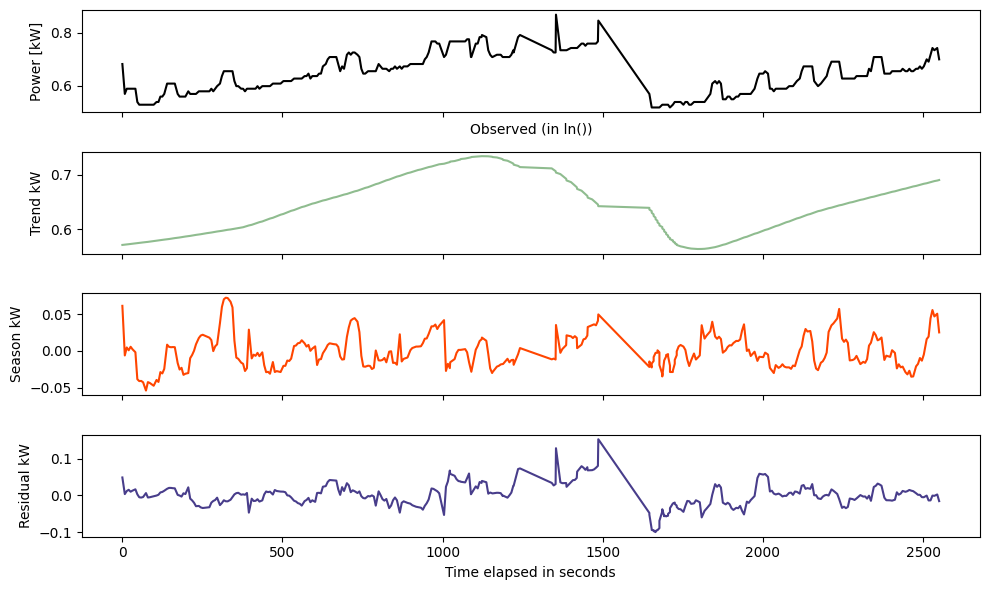

In [145]:
# first step stl
testData_01_power_df = testData_01_power_df.sort_index() #does that even make sense? It did although I assumed data was ordered in the csv file
# trend = math.ceil(1.5*60/(1- 1.5/301))
stl_testData_power = STL.STL(testData_01_power_df["Power"], period=60)
res = stl_testData_power.fit()

fig, axes = plt.subplots(4, 1, figsize=(10,6), sharex=True)
axes[0].plot(testData_01_power_df.index, res.observed, color="black")
axes[0].set_ylabel("Power [kW]")
axes[0].set_xlabel("Observed (in ln())")

axes[1].plot(testData_01_power_df.index, res.trend, color="darkseagreen")
axes[1].set_ylabel("Trend kW")

axes[2].plot(testData_01_power_df.index, res.seasonal, color="orangered")
axes[2].set_ylabel("Season kW")

axes[3].plot(testData_01_power_df.index, res.resid, color="darkslateblue")
axes[3].set_ylabel("Residual kW")
axes[3].set_xlabel("Time elapsed in seconds")

plt.tight_layout()
plt.show()

In [152]:
# ARIMA
residual_df = pd.DataFrame(res.resid)
testData_01_power_df.rename(columns= {"Zeitstempel": "Timestamp", "Strom": "Power"}, inplace = True)
residual_df.rename(columns={"resid" : "PowerDifference"}, inplace=True)
print(residual_df)


arima_Model = ARIMA(residual_df["PowerDifference"], order=(2,1,1))
arima_Result = arima_Model.fit()


forecast = arima_Result.forecast(steps=50)
print(forecast)

           PowerDifference
Timestamp                 
0.000             0.048636
7.626             0.003368
13.733            0.011686
19.753            0.015070
25.780            0.009861
...                    ...
2523.443         -0.013752
2529.466         -0.000725
2535.463         -0.001344
2544.383          0.002315
2550.403         -0.015801

[364 rows x 1 columns]
364   -0.011789
365   -0.012339
366   -0.012254
367   -0.012267
368   -0.012265
369   -0.012265
370   -0.012265
371   -0.012265
372   -0.012265
373   -0.012265
374   -0.012265
375   -0.012265
376   -0.012265
377   -0.012265
378   -0.012265
379   -0.012265
380   -0.012265
381   -0.012265
382   -0.012265
383   -0.012265
384   -0.012265
385   -0.012265
386   -0.012265
387   -0.012265
388   -0.012265
389   -0.012265
390   -0.012265
391   -0.012265
392   -0.012265
393   -0.012265
394   -0.012265
395   -0.012265
396   -0.012265
397   -0.012265
398   -0.012265
399   -0.012265
400   -0.012265
401   -0.012265
402   -0.012265
4

c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scikit-learn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\PLenski\Desktop\Bachelor\SourceCode\scik